<a href="https://www.nvidia.com/en-us/deep-learning-ai/education/"> <img src="images/DLI Header.png" alt="Header" style="width: 400px;"/> </a>

# Network Anomaly Detection using Autoencoders

- Ananth Sankar, Solutions Architect at NVIDIA.
- Eric Harper, Solutions Architect, Global Telecoms at NVIDIA.

Welcome to the second lab of this series!

In the previous lab we used XGBoost, a powerful and efficient tree-based algorithm for classification of anomalies. We were able to almost perfectly identify the anomalous data in the KDD99 dataset and which type of anomaly occurred.  However, in the real-world, *labeled* data can be expensive and hard to come by. Especially with network security, zero-day attacks can be the most challenging and also the most important attacks to detect. Since, by definition, these attacks are happening for the first time, there will be no way to have labels from them.

So how do we approach *this* problem?

For starters, we could have security analysts investigate the network packets and label anomalous ones. But that solution doesn't scale and our models might have difficulty identifying attacks that haven't occurred before. 

Our solution *needs to use* "unsupervised learning." Unsupervised learning is the class of machine learning and deep learning algorithms that enable us to draw inferences from our dataset without labels.



In this lab we will use autoencoders (AEs) to detect anomalies in the KDD99 dataset. There are a lot of advantages to using autoencoders for detecting anomalies. One main advantage is the that AEs can learn non-linear relationships in the data.

While we will not be using the labels in the KDD99 dataset explicitly for model training, we will be using them to evaluate how well our model is doing at detecting the anomalies.  We will also use the labels to see if the AE is embedding the anomalies in latent space according to the type of anomaly.

Note that we will be using Keras as the deep learning framework for this lab. Keras is an open source neural network library written in Python and it is designed to enable fast experimentation with deep neural networks. 

In [29]:
!pip install tensorflow pydot -q

In [13]:
# Import libraries that will be needed for the lab
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image
import os, datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.cluster import KMeans

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.utils import plot_model
%load_ext tensorboard

import pickle

import random
random.seed(123)

data_path = './data'

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Section 1: Dataset

Let's load the preprocessed train and test data that we created in Lab 1. We'll think through the same research question we did in Lab 1 again since it helps us to understand exactly *how* our model is learning. 

*How does the ratio of anomalies to normal data impact results and why?*


Recall that when using XGBoost, the ratio didn't impact training meaningfully. Anomalies were simply *a class* of our dataset, not made special in any way by their rare nature. Using AutoEncoders, you'll see that that's no longer true. We'll explore the questions of *how rare is rare enough?* and *how does that impact our ability to identify multiple classes of anomalies?*.

In the cell below, choose to either use 1% or 5% anomaly in your dataset by setting the <code>pct_anomalies</code> parameter to .01 or .05 respectively. If you are taking this in an in-person workshop, choose a partner and do both so you can compare and contrast.

In [14]:
pct_anomalies = .01

In [18]:
!python Lab2-preprocess_data.py --pct_anomalies $pct_anomalies

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [19]:
filename = './preprocessed_data_full.pkl'
input_file = open(filename,'rb')
preprocessed_data = pickle.load(input_file)
input_file.close()

Recall that we have constructed train and test sets where we removed most of anomalous data in the KDD99 dataset.  This lets us simulate a more realistic anomaly detection problem where anomalies only comprise a small percentage of the data.  We also trained a label encoder on the anomalous labels.  This will allow us to go back and forth between labels and their encoded values.

In [20]:
for key in preprocessed_data:
    print(key)

x_train
y_train
x_test
y_test
le


In [21]:
le = preprocessed_data['le']
x_train = preprocessed_data['x_train']
y_train = preprocessed_data['y_train']
x_test = preprocessed_data['x_test']
y_test = preprocessed_data['y_test']

### 1.1 Data Preprocessing

Most of the data preprocessing has already been done in Lab 1. We one-hot encoded the categorical variables and separated the labels off from the input data. After this the data was ready for the XGBoost model.  For training deep autoencoder models, the input data will also have to be scaled between 0 and 1.

In [22]:
# Normalize the testing and training data using the MinMaxScaler from the scikit learn package
scaler = MinMaxScaler()

# Make sure to only fit the scaler on the training data
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# convert the data to FP32
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

## Section 2: Deep Autoencoders

Autoencoders are a subset of neural network architectures where the output dimension is the same as the input dimension. Autoencoders have two networks, an encoder and a decoder.  The encoder encodes its input data into a smaller dimensional space, called the latent space.  The decoder network tries to reconstruct the original data from the latent encoding. Typically, the encoder and decoder are symmetric, and the latent space is a bottleneck. The autoencoder has to learn essential characteristics of the data to be able to do a high-quality reconstruction of the data during decode.

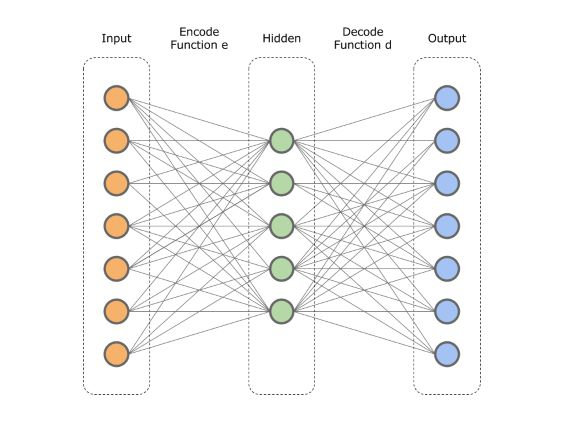

In this lab, we'll be using deep autoencoders with dropout. Dropout is a way to control overfitting by randomly
omitting subsets of features at each iteration of a training procedure.

### 2.1 Keras Model Definition 

Next we will chose the hyperparameters for the Keras autoencoder model.

- batch_size: this determines how many datapoints we use for each gradient update. Choosing a large batch size will make the model train faster but it might not result in the best accuracy or generalization.

- latent_dim: this determines the size of our bottleneck. Higher values add network capacity while lower values increase the efficiency of the encoding.

- max_epochs: should be high enough for the network to learn from the data, but not so high as to overfit the training data or diverge to a worse result

In [23]:
input_dim = x_train.shape[1]

# model hyperparameters
batch_size = 512

latent_dim = 4

max_epochs = 10 

### 2.2 Encoder Network

Here we define the encoder network.

In [24]:
# The encoder will consist of a number of dense layers that decrease in size 
# as we taper down towards the bottleneck of the network, the latent space
input_data = Input(shape=(input_dim,), name='encoder_input')

# hidden layers
encoder = Dense(96,activation='tanh', name='encoder_1')(input_data)
encoder = Dropout(.1)(encoder)
encoder = Dense(64,activation='tanh', name='encoder_2')(encoder)
encoder = Dropout(.1)(encoder)
encoder = Dense(48,activation='tanh', name='encoder_3')(encoder)
encoder = Dropout(.1)(encoder)
encoder = Dense(16,activation='tanh', name='encoder_4')(encoder)
encoder = Dropout(.1)(encoder)

# bottleneck layer
latent_encoding = Dense(latent_dim, activation='linear', name='latent_encoding')(encoder)

Here we instantiate the encoder model, look at a summary of its layers, and then visualize it.

In [25]:
encoder_model = Model(input_data, latent_encoding)

encoder_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 110)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_1 (Dense)               │ (None, 96)             │        10,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_2 (Dense)               │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_3 (Dense)               │ (None, 48)             │         3,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_4 (Dense)               │ (None, 16)             │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_encoding (Dense)         │ (None, 4)              │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,836 (81.39 KB)

 Trainable params: 20,836 (81.39 KB)

 Non-trainable params: 0 (0.00 B)

You must install pydot (`pip install pydot`) for `plot_model` to work.


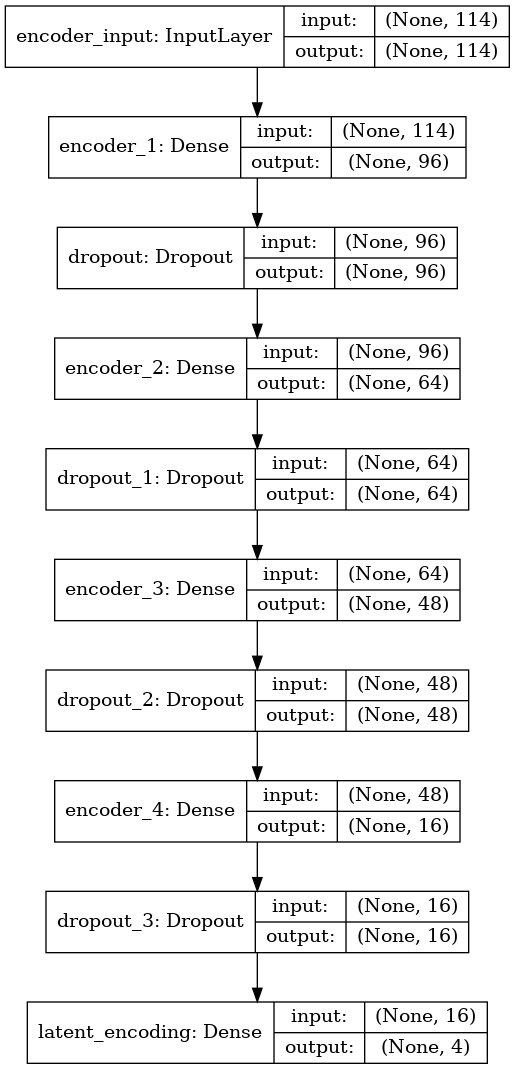

In [31]:
plot_model(
    encoder_model, 
    to_file='encoder_model.png', 
    show_shapes=True, 
    show_layer_names=True, 
    rankdir='TB' # TB for top to bottom, LR for left to right
)

Image(filename='./images/encoder_model.png')

### 2.3 Decoder Network [Exercise]

The decoder network comes after the bottle neck of the auto encoder. It takes latent values as input and then outputs reconstructions of the original input data.

In [32]:
# The decoder network is a mirror image of the encoder network
decoder = Dense(16, activation='tanh', name='decoder_1')(latent_encoding)
decoder = Dropout(.1)(decoder)
decoder = Dense(48, activation='tanh', name='decoder_2')(decoder)
decoder = Dropout(.1)(decoder)
decoder = Dense(64, activation='tanh', name='decoder_3')(decoder)
decoder = Dropout(.1)(decoder)
decoder = Dense(96, activation='tanh', name='decoder_4')(decoder)
decoder = Dropout(.1)(decoder)

# The output is the same dimension as the input data we are reconstructing
reconstructed_data = Dense(input_dim, activation='linear', name='reconstructed_data')(decoder)

We instantiate the autoencoder model, look at a summary of it's layers, and visualize it.

In [33]:
autoencoder_model = Model(input_data, reconstructed_data)

autoencoder_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 110)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_1 (Dense)               │ (None, 96)             │        10,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_2 (Dense)               │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_3 (Dense)               │ (None, 48)             │         3,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_4 (Dense)               │ (None, 16)             │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_encoding (Dense)         │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_1 (Dense)               │ (None, 16)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_2 (Dense)               │ (None, 48)             │           816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_3 (Dense)               │ (None, 64)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_4 (Dense)               │ (None, 96)             │         6,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reconstructed_data (Dense)      │ (None, 110)            │        10,670 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,778 (163.20 KB)

 Trainable params: 41,778 (163.20 KB)

 Non-trainable params: 0 (0.00 B)

You must install pydot (`pip install pydot`) for `plot_model` to work.


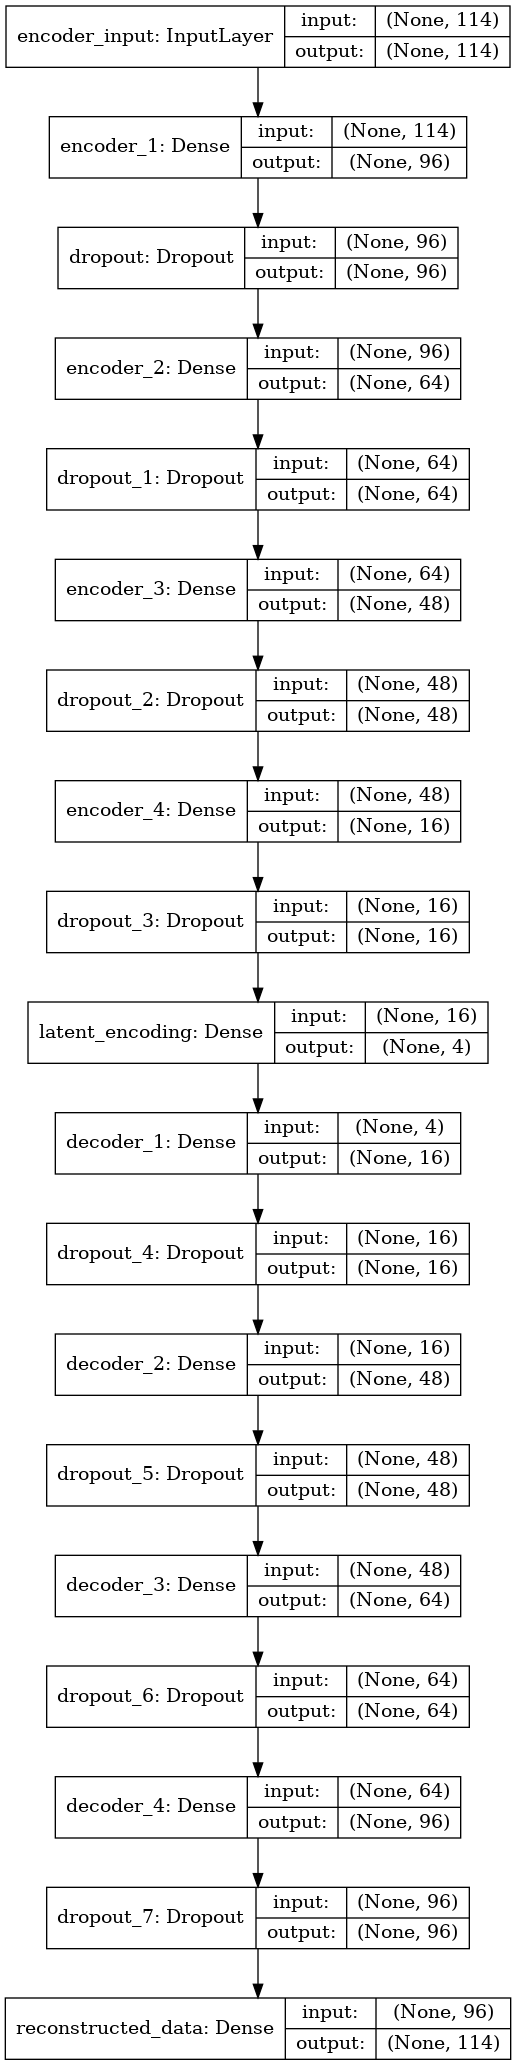

In [35]:
plot_model(
    autoencoder_model, 
    to_file='autoencoder_model.png', 
    show_shapes=True, 
    show_layer_names=True, 
    rankdir='TB' # TB for top to bottom, LR for left to right
)

Image(filename='./images/autoencoder_model.png')

### 2.4 Compile the Model

Here we specify the loss function [Mean Squared Error](https://en.wikipedia.org/wiki/Mean_squared_error) and the optimizer [Adam](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Adam).

In [36]:
opt = optimizers.Adam(learning_rate=.00001)

autoencoder_model.compile(optimizer=opt, loss='mse', metrics=['accuracy'])

### 2.5 Train on the KDD99 Data

Let us look at the feature and label columns of our training set before we start training our XG Boost model. Notice we are not using any labels, `y_train` or `y_test`.

In [37]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir,profile_batch=0,update_freq='epoch',histogram_freq=1)

train_history = autoencoder_model.fit(x_train, x_train,
        shuffle=True,
        epochs=max_epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test),
        callbacks=[tensorboard_callback])

Epoch 1/10
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.0854 - loss: 0.0644 - val_accuracy: 0.3848 - val_loss: 0.0181
Epoch 2/10
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.1610 - loss: 0.0267 - val_accuracy: 0.1649 - val_loss: 0.0117
Epoch 3/10
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.1546 - loss: 0.0184 - val_accuracy: 0.1862 - val_loss: 0.0087
Epoch 4/10
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.1505 - loss: 0.0140 - val_accuracy: 0.2202 - val_loss: 0.0071
Epoch 5/10
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.1457 - loss: 0.0115 - val_accuracy: 0.2090 - val_loss: 0.0065
Epoch 6/10
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.1381 - loss: 0.0100 - val_accuracy: 0.1506 - val_loss: 0.0061
Epoch 7/10
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.1354 - loss: 0.0091 - val_accuracy: 0.1475 - val_loss: 0.0054
Epoch 8/10
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.1548 - loss: 0.0081 -

Let's inspect the loss on the train and validation sets.  You should see the loss on the training data and the loss on the validation data converging towards zero.  Notice that the training loss is actually higher than the validation loss.  That's because when we train the network, we are using dropout, which again, "is a way to control overfitting by randomly omitting subsets of features at each iteration of a training procedure." When we validate, we remove the dropout, which gives our network its full strength.

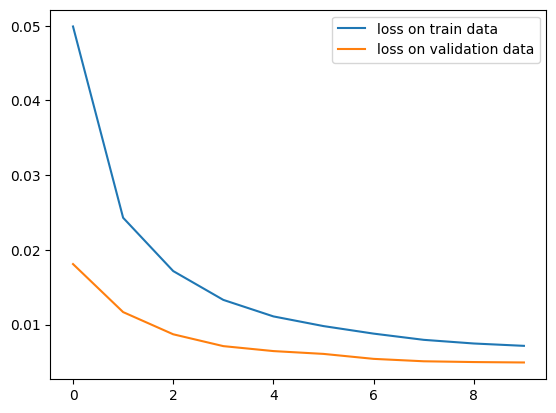

In [38]:
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.legend(['loss on train data', 'loss on validation data'])

### 2.6 Inspect the TensorBoard

In [39]:
%tensorboard --logdir logs

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 30510.

## Section 3: Anomaly Detection

In order to detect anomalies, we need to do the following:

1. Reconstruct the test data. 
2. Compute the reconstruction scores using MSE. 
3. Set a threshold to label test datapoints as anomalies. 

In [40]:
# Reconstruct the data using our trainined autoencoder model.
x_test_recon = autoencoder_model.predict(x_test)

# the reconstruction score is the mean of the reconstruction errors (relatively high scores are anomalous)
reconstruction_scores = np.mean((x_test - x_test_recon)**2, axis=1)

7676/7676 ━━━━━━━━━━━━━━━━━━━━ 6s 775us/step


Let's analyze the reconstruction scores.

In [41]:
# store the reconstruction data in a Pandas dataframe
anomaly_data = pd.DataFrame({'recon_score':reconstruction_scores})

# if our reconstruction scores our normally distributed we can use their statistics
anomaly_data.describe()

,recon_score
count,245627.000000
mean,0.004931
std,0.008145
min,0.000076
25%,0.001582
50%,0.002219
75%,0.004685
max,1.514244


<Axes: xlabel='Reconstruction Score', ylabel='Frequency'>

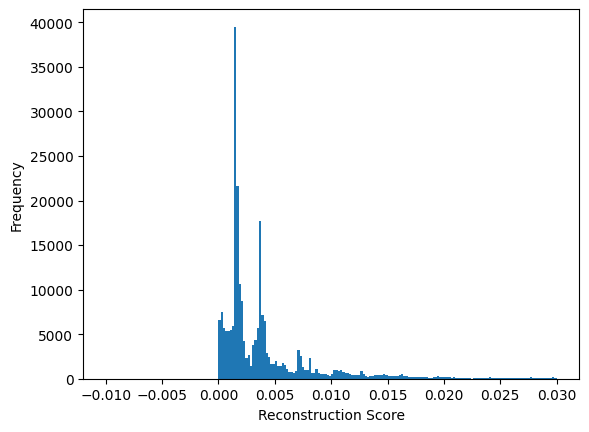

In [42]:
# plotting the density will give us an idea of how the reconstruction scores are distributed
plt.xlabel('Reconstruction Score')
anomaly_data['recon_score'].plot.hist(bins=200, range=[-.01, .03])

Now we define a function to convert the labels to binary. Recall that the label encoder from the previous lab encoded normal data as 11. `labels`=11 therefore corresponds to normal data and `labels`!=11 corresponds to anomalous data.

In [43]:
def convert_label_to_binary(label_encoder, labels):
    normal_idx = np.where(label_encoder.classes_ == 'normal.')[0][0]
    my_labels = labels.copy()
    my_labels[my_labels != normal_idx] = 1 
    my_labels[my_labels == normal_idx] = 0
    return my_labels

## Section 4: Model Validation

In [44]:
# convert our labels to binary
binary_labels = convert_label_to_binary(le, y_test)

# add the binary labels to our anomaly dataframe
anomaly_data['binary_labels'] = binary_labels

# let's check if the reconstruction statistics are different for labeled anomalies
anomaly_data.groupby(by='binary_labels').describe()

recon_score                                                    \
                    count      mean       std       min       25%       50%   
binary_labels                                                                 
0                243161.0  0.004434  0.006366  0.000076  0.001582  0.002184   
1                  2466.0  0.053918  0.013684  0.004713  0.047722  0.047722   

                                   
                    75%       max  
binary_labels                      
0              0.004522  1.514244  
1              0.047722  0.086392

We can see from the above that the anomalous data has a mean reconstruction score of </b>0.05</b> while the normal data has a score of <b>~0.004</b>. This is a good sign that our autoencoder has learned to reconstruct normal data but fails to reconstruct anomalous data.

Let's see how our ROC curve looks with the reconstruction score.

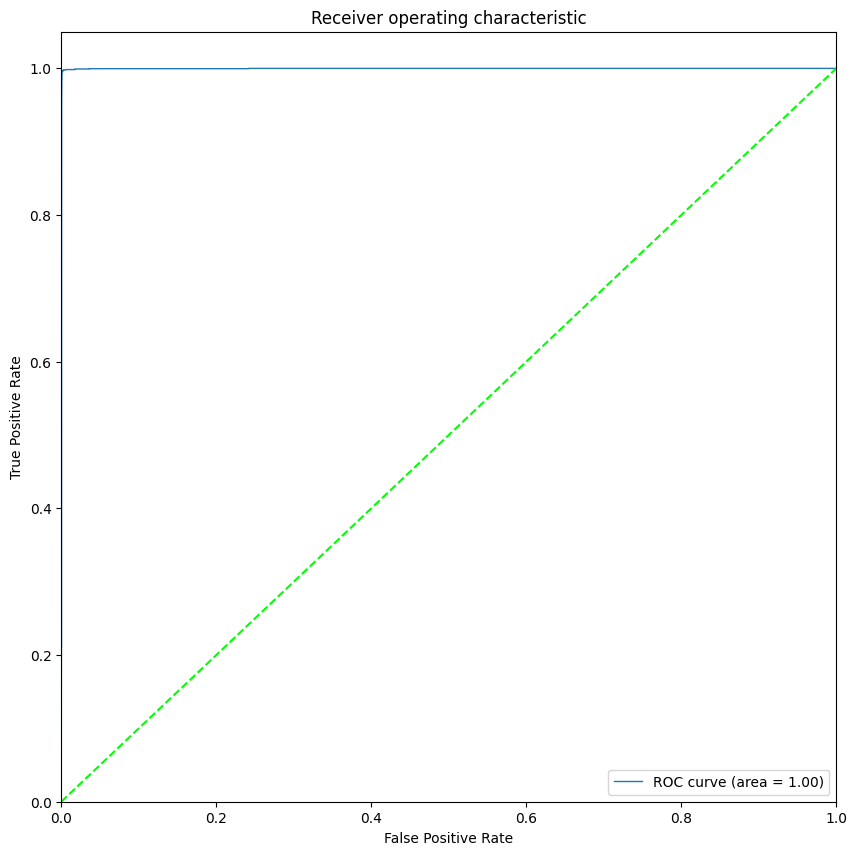

In [45]:
fpr, tpr, thresholds = roc_curve(binary_labels, reconstruction_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='lime', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

The ROC Curve looks great and we have a perfect AUC score.  This is a good sign, but we still need to verify that we can set a threshold which accomplishes our business objective. In this lab we are looking to detect as many anomalies as possible while also minimizing the number of false positives.

### 4.1 Thresholds

There are number of ways to set thresholds.  We give some examples below and we encourage you to experiment by setting your own thresholds and see how they affect the model.

In [46]:
# We can pick the threshold based on maximizing the true positive rate (tpr) 
# and minimizing the false positive rate (fpr)
optimal_threshold_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_threshold_idx]
print(optimal_threshold)

0.03552515


In [47]:
# Or we assume our reconstructions are normally distributed and label anomalies as those
# that are a number of standard deviations away from the mean
recon_mean = np.mean(reconstruction_scores)
recon_stddev = np.std(reconstruction_scores)

stats_threshold = recon_mean + 5*recon_stddev
print(stats_threshold)

0.045654150657355785


Now, similar to lab1, let us plot the confusion matrix in order to visualize the results.

In [48]:
# play around here and find the threshold that works for you

#thresh = optimal_threshold
thresh = stats_threshold



print(thresh)

pred_labels = (reconstruction_scores > thresh).astype(int)

results = confusion_matrix(binary_labels, pred_labels) 


0.045654150657355785


### 4.2 Confusion Matrix

Note, in the next lab, you will be asked to implement your own confusion matrix since it's a very useful tool we want to draw your attention to. Copy, paste, and store this cell somewhere safe.

Confusion Matrix: 


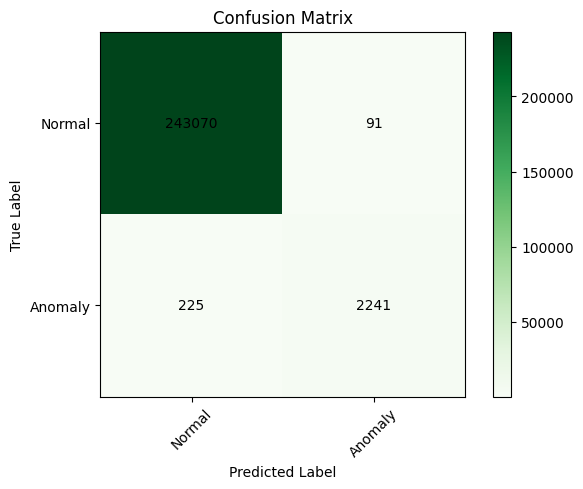

In [49]:
print ('Confusion Matrix: ')

def plot_confusion_matrix(cm, target_names, title='Confusion Matrix', cmap=plt.cm.Greens):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()

    width, height = cm.shape

    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')


plot_confusion_matrix(results, ['Normal','Anomaly'])

Analyzing the confusion matrix, we see that we get optimal results.  The algorithm is labeling most of the normal data anomalous data correctly while mislabeling very infrequently. 

Returning to our research question: How does the proportion of anomalies to normal data impact the ability for a Deep Learning based AutoEncoder model to detect them?

## Section 5: Multi-class Classification

This exercise will show how we could potentially create labeled data by using k-means clustering algorithm to group our predicted anomalies in latent space. The goal of this algorithm is to find groups in the data, with the number of groups represented by the variable K. The algorithm works iteratively to assign each data point to one of K groups based on the features that are provided. Data points are clustered based on feature similarity.

For each test datapoint that we've labeled as an anomaly, we will label the clusters based on the label that appears most in the cluster.

In [50]:
# subset the test data so that we are only looking at the predicted anomalies
x_test_df = pd.DataFrame(x_test)

test_anomalies = x_test_df[pred_labels.astype('bool')]

y_test_df = pd.DataFrame(y_test)
test_anomalies_labels = y_test_df[pred_labels.astype('bool')]

# encode the test anomalies into latent space
encoded_test_anomalies = encoder_model.predict(test_anomalies)

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [51]:
# apply KMeans to the data in order to create clusters of anomalies
kmeans = KMeans(n_clusters=10, random_state=123)
kmeans.fit(encoded_test_anomalies)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=10, random_state=123)

In [52]:
clusters = pd.DataFrame({'cluster':kmeans.labels_, 'label':test_anomalies_labels[0]})

most_frequent_labels = clusters.groupby('cluster').label.value_counts()

print(most_frequent_labels)

cluster  label
0        18       1719
1        9         483
2        11         13
         9           1
3        11         22
4        17          8
         15          3
         9           2
5        11          5
         9           1
6        9          15
         11          8
         17          4
7        11         19
         9           5
8        11         18
9        11          6
Name: label, dtype: int64


If we replace our clusters with the label that shows up most frequently for each cluster, then we can compare how well the anomalies are clustered together in latent space.

In [53]:
# this dictionary will map our cluster values to the labels that appear most frequently
cluster_to_label = {}
for cluster in range(0, 10):
    label = most_frequent_labels[cluster].index[0]
    cluster_to_label[cluster] = label

# we then replace the clusters inplace by their label values
clusters.cluster.replace(cluster_to_label, inplace=True)

Now we can plot the confusion matrix to see how well our clusters agree with the labels

Confusion Matrix :


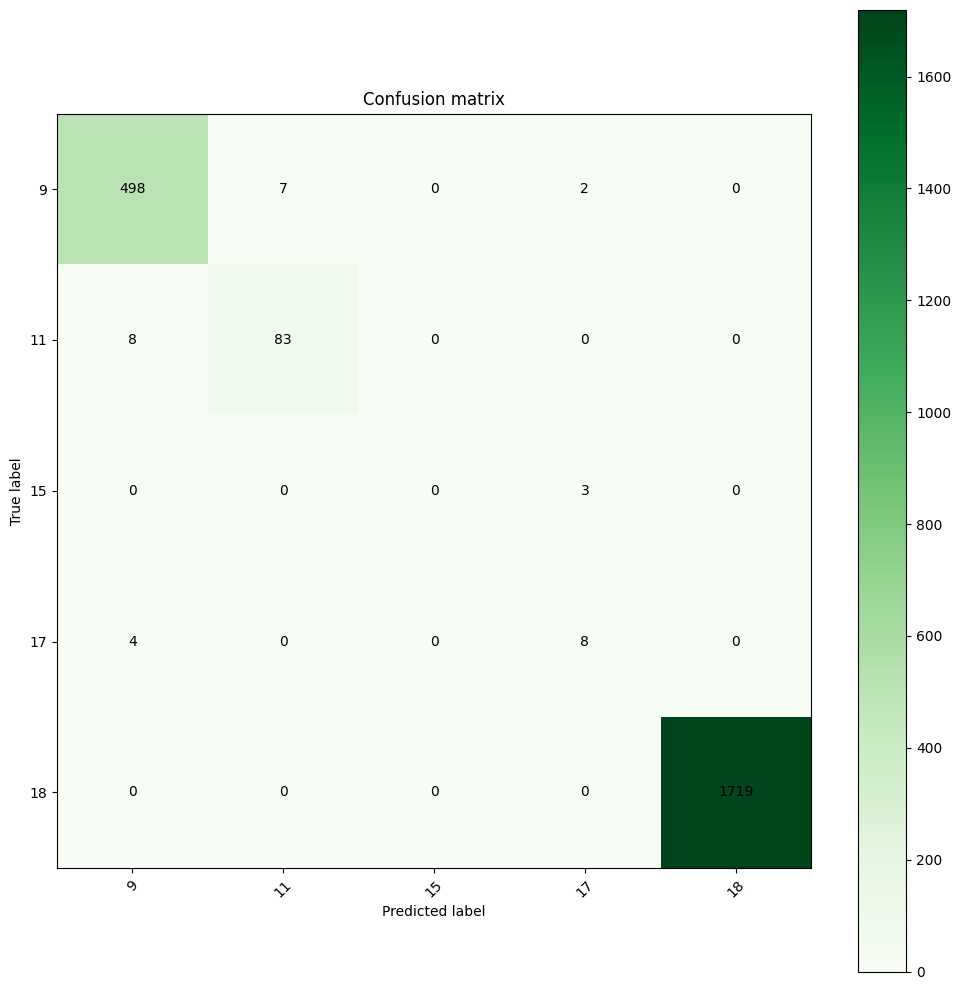

In [54]:
target_names = np.unique(list(clusters.label))
cm = confusion_matrix(clusters.label, clusters.cluster)

print ('Confusion Matrix :')

def plot_confusion_matrix(cm,target_names, title='Confusion matrix', cmap=plt.cm.Greens):
    plt.figure(figsize=(10,10),)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()

    width, height = cm.shape

    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


plot_confusion_matrix(cm,target_names)

## Conclusions

- We were successfully able to detect KDD99 anomalies without using the labels for training by using a deep autoencoder.
- We then showed that autoencoder model was embedding the anomalous datapoints in latent space according to the type of anomaly.
- This means we could begin labeling the anomalous data by having SMEs look at a small fraction of the total data.

## References

<ol>
    <li>Haowen, Chen, Zhao, Li, Zeyan, Zhihan, . . . Honglin. (2018, February 12). Unsupervised Anomaly Detection via Variational Auto-Encoder for Seasonal KPIs in Web Applications. Retrieved from https://arxiv.org/abs/1802.03903</li>
    
<li>Ellison, D. (n.d.). Fraud Detection Using Autoencoders in Keras with a TensorFlow Backend. Retrieved from https://www.datascience.com/blog/fraud-detection-with-tensorflow</li>
<li>
    Sadanand Singh (n.d.). A Practical guide to Autoencoders Retrieved from https://sadanand-singh.github.io/posts/autoencoders/
    </li>
<li>
    Jeremy Jordan (n.d.). Variational autoencoders. Retrieved from https://www.jeremyjordan.me/variational-autoencoders/
    </li>

<a href="https://www.nvidia.com/en-us/deep-learning-ai/education/"> <img src="images/DLI Header.png" alt="Header" style="width: 400px;"/> </a>